# **Data Preprocessing: Stage Two**

1.	Splitting the training data (windowed under sampling):
-	Get the durations for all the species
-	From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training
-	The remaining samples will be the validation data
-	Normalize the audio samples
-	Turn all the data into windowed Mel-spectrograms (window the audio using half overlap and normalization of spectrograms)
-	Since the audio samples are the same duration, the dimensions of the Mel will be the same
-	(Save that into a pkl file or something for easy access for all the models)



I noticed that the volumes of the samples where very different. 
* I will try first normalizing the volume of all samples between 0 and 1. 
* Then i will convert those to mel spectrograms, and then normalize those between 0 and 1 also between sample

I noticed that the lengths are very different so scaling it by stretching and shrinking the data basically gave the machine nonsense and thats why the accuracy was bad. 

I can try using audio samples that are greater than 2 seconds long, and use a 2 second window and a 1 second overlap to create the spectrograms with each sample, keeping track of the class of the audio sample. This should make all the spectrograms have the same size and surely improve the results a bit. 

I will experiment with different window sizes and save those files in pkl for later. 

* I will do 2 sec with 1 sec overlap
* I will do 4 sec with 2 sec overlap
* I will do 6 sec with 3 sec overlap
* I will do 8 sec with 4 sec overlap

This is just to show how one improvement (overlap) can affect results

In [27]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage

In [2]:
df_train = pd.read_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/traintest-split/train.csv') # Reading in training data
df_train.head()

,Unnamed: 0,primary_label,type,rating,filename,duration,filename_npy
0,7169,gargan,song,4.5,gargan/XC190746.ogg,6.660000,gargan/XC190746.npy
1,4476,combul2,song,3.5,combul2/XC443499.ogg,47.592000,combul2/XC443499.npy
2,7483,gnbcam2,blank,1.5,gnbcam2/XC45693.ogg,16.378812,gnbcam2/XC45693.npy
3,13632,tafpri1,call,4.0,tafpri1/XC363881.ogg,19.043250,tafpri1/XC363881.npy
4,14773,wbrcha2,song,3.5,wbrcha2/XC227360.ogg,93.753500,wbrcha2/XC227360.npy


In [3]:
df_train['primary_label'].value_counts()

primary_label
litegr     262
combul2    220
rbsrob1    190
greegr     183
blakit1    182
gnbcam2    174
rerswa1    156
somgre1    133
blbpuf2    123
ratcis1    123
tafpri1    121
colsun2    121
egygoo     113
categr     104
carcha1     97
gargan      94
yertin1     94
grecor      92
fotdro5     89
wbrcha2     86
Name: count, dtype: int64

In [4]:
filepaths = df_train['filename_npy']
filepaths

0        gargan/XC190746.npy
1       combul2/XC443499.npy
2        gnbcam2/XC45693.npy
3       tafpri1/XC363881.npy
4       wbrcha2/XC227360.npy
                ...         
2752    rerswa1/XC278139.npy
2753    rerswa1/XC310320.npy
2754    combul2/XC239845.npy
2755    somgre1/XC154317.npy
2756      grecor/XC27183.npy
Name: filename_npy, Length: 2757, dtype: object

## Get the durations for all the species

In [6]:
duration_sum = df_train[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,primary_label,duration,duration_mins
19,yertin1,3039.921813,50.665364
18,wbrcha2,4188.970125,69.816169
17,tafpri1,3091.966500,51.532775
16,somgre1,5975.104500,99.585075
15,rerswa1,5105.715938,85.095266
14,rbsrob1,8089.174500,134.819575
13,ratcis1,3813.778563,63.562976
12,litegr,6256.380688,104.273011
11,greegr,3072.503938,51.208399
10,grecor,6831.784187,113.863070


### From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training

In [7]:
train_duration_max = np.min(duration_sum['duration'])*0.7 # maximum total duration for each species in the training set in seconds using sample with shortest duration
train_duration_max

1516.1806624999997

In [8]:
shuffled_train = df_train.sample(frac=1, random_state=1414) # shuffle the original df before splitting to train/val

In [9]:
# Adding samples to each species until the duration of each species = train_duration_max
tr = pd.DataFrame()

for species in shuffled_train['primary_label'].unique():
  species_df = shuffled_train[shuffled_train['primary_label'] == species].copy()
  duration = 0

  while duration <= train_duration_max:
        sample = species_df.sample(n=1, replace=False, random_state=1)  # draw one sample and don't put it back
        species_df.drop(sample.index, inplace=True)
        duration += sample['duration'].item()
        tr = pd.concat([tr, sample])

In [11]:
val = df_train.drop(tr.index) # Samples not selected in train, take them to val

### Confirm no duplicates and the samples in validation set are not in the training set

In [12]:
assert len(tr) == tr['filename_npy'].nunique()

In [13]:
assert len(val) == val['filename_npy'].nunique()

In [14]:
is_present = val.isin(tr).any().any()

assert not is_present

### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [15]:
tr['set'] = 'tr'
val['set'] = 'val'

merged_train = pd.concat([tr, val])

In [16]:
duration_sum = merged_train[['primary_label', 'duration', 'set']].groupby(['set', 'primary_label']).sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,set,primary_label,duration,duration_mins
39,val,yertin1,1432.661500,23.877692
19,tr,yertin1,1607.260313,26.787672
18,tr,wbrcha2,1524.414750,25.406912
38,val,wbrcha2,2664.555375,44.409256
17,tr,tafpri1,1536.814187,25.613570
37,val,tafpri1,1555.152312,25.919205
16,tr,somgre1,1569.966250,26.166104
36,val,somgre1,4405.138250,73.418971
35,val,rerswa1,3541.760625,59.029344
15,tr,rerswa1,1563.955312,26.065922


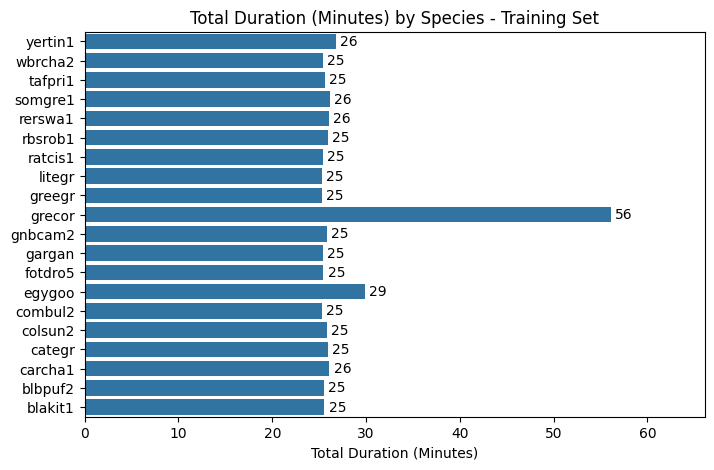

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

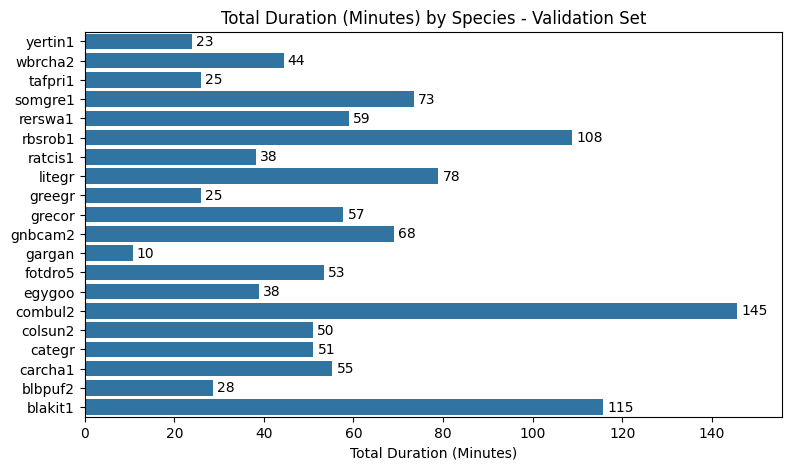

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [19]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-2-trainval.csv', index=False)

# Feature Extraction

Turning the data into Mel-spectrograms 

In [20]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/'  # Where to save Mel spectrograms
n_mels = 128
target_shape = (128,128)
sr = 16000

In [21]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-2-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [63]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/train_mel_spectrograms-2s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-2/val_mel_spectrograms-4s.pkl'


In [23]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [60]:
# Function to generate mel spectrogram with sliding window and overlap
def get_mel_spectrogram_with_window(npy_file, sr=sr, n_mels=128, hop_length=512, window_size=2, overlap=1, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        return None  # Skip this sample and remove short samples
    
    audio_data = normalize_audio(audio_data)
    
    # Define the step based on the window and overlap (in samples, not time)
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    mel_spectrograms = []
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
        
        # Resize the mel spectrogram to 128x128
        mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                          target_shape[1] / mel_spectrogram_db.shape[1]))
        mel_spectrograms.append(mel_spectrogram_resized)
    
    return mel_spectrograms  # Returns a list of 128x128 mel spectrograms

In [62]:
# Function to generate and organize Mel spectrograms in a dictionary
def prepare_data_for_model_dict(npy_files, labels_encoded, sr=sr, window_size=2, overlap=1, target_shape=(128, 128)):
    mel_spectrograms_dict = {}

    for npy_file, label in tqdm(zip(npy_files, labels_encoded), desc="Processing files"):
        mel_specs = get_mel_spectrogram_with_window(npy_file, sr=sr, window_size=window_size, overlap=overlap, target_shape=target_shape)
        if mel_specs is None:
            continue  # Skip short files
        
        for i, mel_spec in enumerate(mel_specs):
            mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add a channel dimension for CNN
            key = f"{npy_file}_window_{i}"  # Create a unique key for each windowed spectrogram
            mel_spectrograms_dict[key] = (mel_spec, label)  # Store the spectrogram and label as a tuple

    return mel_spectrograms_dict


## Processing the training data

In [51]:
train_mel_spectrograms = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training Mel spectrograms", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    mel_spec_dict = prepare_data_for_model_dict([npy_file], [label])  # Pass as lists to match function signature
    
    # Store each windowed Mel spectrogram with its respective label
    for key, value in mel_spec_dict.items():
        train_mel_spectrograms[key] = value  # key is the windowed filename, value is (mel_spectrogram, label)


Processing files: 1it [00:00, 236.75it/s]%|          | 0/933 [00:00<?, ?it/s]
Processing files: 1it [00:00,  3.54it/s]
Processing files: 1it [00:00, 17.33it/s]0%|          | 4/933 [00:00<03:37,  4.27it/s]
Processing files: 1it [00:00,  2.94it/s]
Processing files: 1it [00:00, 30.53it/s]1%|          | 6/933 [00:01<03:21,  4.61it/s]
Processing files: 1it [00:00,  1.30it/s]
Processing files: 1it [00:00, 15.68it/s]1%|          | 9/933 [00:02<03:58,  3.87it/s]
Processing files: 1it [00:00,  5.18it/s]
Processing files: 1it [00:00, 29.88it/s]1%|▏         | 12/933 [00:02<03:02,  5.05it/s]
Processing files: 1it [00:00,  1.55it/s]
Processing files: 1it [00:00, 13.49it/s]2%|▏         | 16/933 [00:03<03:06,  4.93it/s]
Processing files: 1it [00:00, 281.48it/s]
Processing files: 1it [00:00,  4.70it/s]
Processing files: 1it [00:00, 12.95it/s]2%|▏         | 19/933 [00:03<02:18,  6.59it/s]
Processing files: 1it [00:00, 745.12it/s]
Processing files: 1it [00:00,  3.18it/s]
Processing files: 1it [00:00, 16

In [54]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_mel_spectrograms, f)

## Processing the validation data

In [55]:
val_mel_spectrograms = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing training Mel spectrograms", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate Mel spectrograms with windowing (this will return a dictionary of multiple windows)
    mel_spec_dict = prepare_data_for_model_dict([npy_file], [label])  # Pass as lists to match function signature
    
    # Store each windowed Mel spectrogram with its respective label
    for key, value in mel_spec_dict.items():
        val_mel_spectrograms[key] = value  # key is the windowed filename, value is (mel_spectrogram, label)


Processing files: 1it [00:00, 21.06it/s]1%|          | 13/1824 [00:04<07:56,  3.80it/s]
Processing files: 1it [00:00,  4.17it/s]
Processing files: 1it [00:00,  2.16it/s]1%|          | 17/1824 [00:04<06:26,  4.68it/s]
Processing files: 1it [00:00, 425.08it/s]%|          | 18/1824 [00:05<08:29,  3.54it/s]
Processing files: 1it [00:00, 449.36it/s]
Processing files: 1it [00:00, 464.69it/s]
Processing files: 1it [00:00, 29.27it/s]
Processing files: 1it [00:01,  1.09s/it]
Processing files: 1it [00:00, 16.40it/s]1%|▏         | 24/1824 [00:07<10:37,  2.83it/s]
Processing files: 1it [00:00,  1.67it/s]
Processing files: 1it [00:00, 20.32it/s]2%|▏         | 28/1824 [00:08<08:26,  3.55it/s]
Processing files: 1it [00:00, 52.26it/s]
Processing files: 1it [00:00, 11.88it/s]
Processing files: 1it [00:00, 11.58it/s]2%|▏         | 31/1824 [00:08<05:12,  5.74it/s]
Processing files: 1it [00:00,  3.55it/s]
Processing files: 1it [00:00, 56.64it/s]2%|▏         | 36/1824 [00:10<13:44,  2.17it/s]
Processing fi

In [56]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_mel_spectrograms, f)

## Plotting the spectrograms

So you can see that its not really a good way to do it this way

In [37]:
def view_mel_spectrogram_by_index(train_mel_spectrograms, index, isTrain=True):
    # Get the key for the chosen index
    key = list(train_mel_spectrograms.keys())[index]
    
    temp_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'
    

    
    # Extract mel spectrogram and label from the dictionary
    mel_spectrogram, label = train_mel_spectrograms[key]
    
    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram.squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram for {label} (Index: {index})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    # Load the original audio and play the windowed audio from the file
    # npy_file = key  # The key contains the filename of the npy file (windowed version)
    # original_audio = np.load(temp_path + npy_file)
    
    # # Play the windowed audio
    # librosa.output.write_wav('temp_windowed_audio.wav', original_audio, sr=sr)
    # print(f"Playing windowed audio for {label} (Index: {index})")

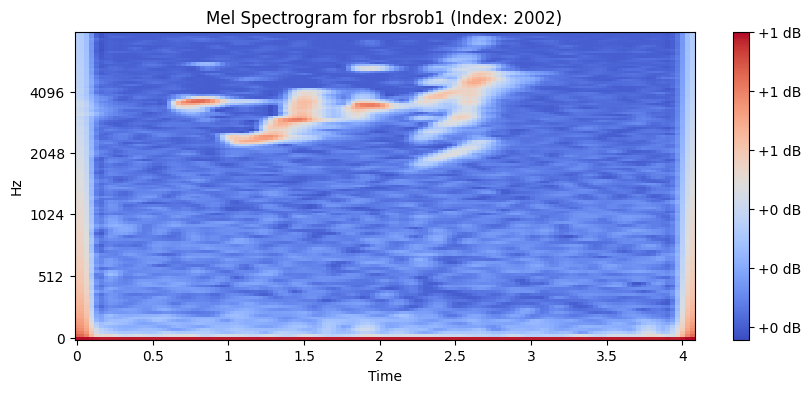

In [44]:
view_mel_spectrogram_by_index(train_mel_spectrograms, 2002)

# Confirming that the pickle files were saved correctly:

In [47]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms_2 = pickle.load(f)

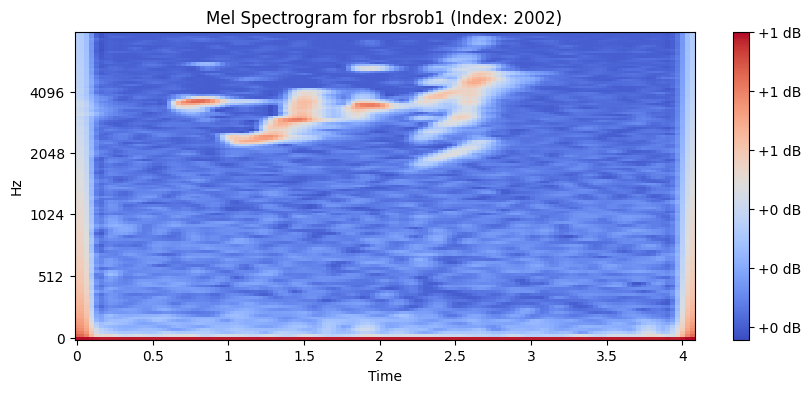

In [48]:
view_mel_spectrogram_by_index(train_mel_spectrograms_2, 2002)